## Inference over a planar robotic arm - edit
This model implements a state-space model for rigid body dynamics of the robotic arm.

Our state-space $\mathbf{x} \in \mathbb{R}^6 $ includes torques $\tau_i$, angles $\theta_i$ and angular velocities $\dot{\theta}_i$. We append all static parameters in $\phi = \{L_{1}, L_{2}, M_{1}, M_{2}\}$.

$$
\mathbf{x} = \begin{pmatrix} \mathbf{x}_1 = \tau_1 \\  \mathbf{x}_2 = \tau_2 \\ \mathbf{x}_3 =\theta_1 \\ \mathbf{x}_4 =\theta_2 \\
\mathbf{x}_5 = \dot{\theta}_1 \\ \mathbf{x}_6 = \dot{\theta}_2 \end{pmatrix}, \quad \mathbf{\dot{x}} = \begin{pmatrix} 0 \\  0 \\ \mathbf{x}_5 \\ \mathbf{x}_6 \\ \mathbf{D}^{-1}(\mathbf{x}_4, \phi) [\begin{pmatrix} \mathbf{x}_1 \\ \mathbf{x}_2 \end{pmatrix} - \mathbf{c}(\mathbf{x}_3, \mathbf{x}_4) -\mathbf{h}(\mathbf{x}_4, \mathbf{x}_5, \mathbf{x}_6) ]
\end{pmatrix}  := a(\mathbf{x})
$$

Where $\mathbf{D} \in \mathbb{R}^{2 \times 2}$ is the inertia tensor and $\mathbf{c},\mathbf{h} \in \mathbb{R}^{2}$ are gravity and fictitious forces vectors, respectively.

Note that $a(\mathbf{x})$ is non-linear because (1) the operation $\mathbf{D}^{-1}(\mathbf{x}_4, \phi) \begin{pmatrix} \mathbf{x}_1 \\ \mathbf{x}_2 \end{pmatrix}$, and (2) $\mathbf{c},\mathbf{h}$ are non-linear functions of the state.

with noise on the torque

$$
\mathbf{\dot{x}} = a(\mathbf{x}) + \begin{pmatrix} 1 \\ 1 \\ 0 \\ 0\\0\\0\end{pmatrix} \nu, \quad \nu \sim \mathcal{N}(0,1)
$$

with Euler discretizetion 

$$
\mathbf{x}_{t+\Delta{t}} = \mathbf{x}_t + \Delta{t}a(\mathbf{x}_t) + \begin{pmatrix} \Delta{t} \\ \Delta{t} \\ 0 \\ 0 \\ 0 \\0 \end{pmatrix} \nu_t \approx \mathbf{x}_t + \Delta{t}a(\mathbf{x}_t) + \begin{pmatrix} \Delta{t} \\ \Delta{t} \\ \sigma \\ \sigma \\ \sigma \\\sigma \end{pmatrix} \nu_t
 $$

where we introduce $\sigma<<\Delta{t}$ to avoid a degenerate distribution.
So our transition is defined as follows:

$$
f(\mathbf{x}_{t+\Delta{t}}|\mathbf{x}_t) = \mathcal{N}(\mathbf{x}_t + \Delta{t}a(\mathbf{x}_t), \text{diag}(\Delta{t}^2,\Delta{t}^2, \sigma, \sigma, \sigma, \sigma))
$$

The emission is 

$$
g(\mathbf{y}_t | \mathbf{x}_t) = \text{FW-KIN}(\mathbf{x}_3, \mathbf{x}_4)
$$

## Concepts Explored in this notebook
The full model from torques to coordinates $\mathbf{\tau} \rightarrow \mathbf{y}$ can be estimated properly with enough independent SMC samplers. In this implementation, the batch dimension of each tensor is used as an independent SMC sampler.

For parameter learning $\theta : = \{M_1, M_2, L_1, L_2\}$, we do not need to use SMC samplers; `batch_size` could be small, even 1. in each SGD iteration, I estimate the states $\mathbf{x}$. Some SGD iterations will be good and some bad, but we assume that they're good enough. Then, offline, we use many independent particle filters.

In [1]:
import os
import inspect
print(os.getcwd())
plot_folder = '3d_arm_dyn_plots'

/home/ubuntu/aesmc/test


In [2]:
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)

In [3]:
parent_dir

'/home/ubuntu/aesmc'

In [4]:
# change dir to import from aesmc
os.chdir(parent_dir)
import aesmc.statistics as statistics
import aesmc.inference as inference
import aesmc.train as train
import aesmc.losses as losses
import aesmc.state as state
import aesmc.math as math
import aesmc.smoothing as smoothing

In [5]:
# change dir to import from aesmc/test
os.chdir(current_dir)
from arm_models import arm_3d_dyn_model # the model script -- distribution objects are defined there
from arm_models import arm_utils # make video, plot post, params to coords
from arm_models import utils_summary
#from arm_models import fw_sim_planar_arm_dyn

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [7]:
# matplotlib general settings 
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

mpl.rcParams['lines.linewidth'] = 4.0

In [8]:
import pickle

# pickle utils
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

def load_object(filename):
    with open(filename, 'rb') as input:  # note rb and not wb
        return pickle.load(input)

In [9]:
def sim_data_from_model(model_dict, num_timesteps, batch_size, repeat_data):
    '''this utility just allows to pass a model_dict with
    "initial", "transition", and "emission" objects.'''
    sim_lats, sim_observs = statistics.sample_from_prior(
        model_dict["initial"], model_dict["transition"],
        model_dict["emission"], num_timesteps, batch_size, repeat_data)
    return sim_lats, sim_observs

In [10]:
def infer_latents(model_dict, observations, num_particles):
    """wrapper around aesmc.inference.infer that allows to input a model_dict
    with the four distribution objects. note, currently 
    Args: 
        model_dict: [dict] with initial, transition, emission, and proposal
        observations: [list] of length num_timepoints with each entry a tensor
        torch.Size(batch_size, dim_obs)
        num_particles: [int]
    Returns:
        list with latents, log_weights, etc."""
    import time as time
    start_time_fw = time.time()
    inference_result = inference.infer(
        inference_algorithm='smc',
        observations=observations,
        initial=model_dict["initial"],
        transition=model_dict["transition"],
        emission=model_dict["emission"],
        proposal=model_dict["proposal"],
        num_particles=num_particles,
        return_log_weights=True,
        return_log_marginal_likelihood=True,
    )
    print('run time for %i timesteps, %i batches, %i particles = %.2f' % \
      (len(observations), observations[-1].shape[0],
       num_particles, time.time() - start_time_fw))
    return inference_result

In [11]:
def plot_simulated_data(lat_data_np, 
                        sim_data_np, 
                        ind_in_batch,
                        label_dict,
                       fig_full_path):
    plt.subplot(121)
    plt.plot(lat_data_np[ind_in_batch, :, :].T)
    plt.title('simulated states')
    plt.ylabel('variable values')
    plt.xlabel('time / dt')
    plt.legend(label_dict["state"])
    plt.subplot(122)
    plt.plot(sim_data_np[ind_in_batch, :, :].T)
    plt.title('simulated observations')
    plt.ylabel('variable values')
    plt.xlabel('time / dt')
    plt.legend(label_dict["obs"])
    plt.tight_layout()
    plt.savefig(fig_full_path)

In [12]:
def plot_inferred_traces_single_run(posterior_summary, lat_data_np, label_list,
                         ind_in_batch, fig_full_path):
    """wrapper around arm_utils.plot_posterior_trace
    ToDo: consider changing the image dims as a func of num_latents"""
    nrows = 3
    num_latents = lat_data_np.shape[1]
    fig, axs = plt.subplots(nrows,
                            int(num_latents / nrows),
                            figsize=(12, 9), #TODO- consider change size
                            sharey=False)
    axs = axs.flatten()
    plt_leg = False
    for i in range(posterior_summary["smooth_mean"].shape[1]):
        if i == num_latents-1:
            plt_leg = True
        arm_utils.plot_posterior_trace(
        post_mean=posterior_summary["smooth_mean"][ind_in_batch, i, :],
        post_var=np.sqrt(posterior_summary["smooth_var"][ind_in_batch, i, :]),
        data_vec=lat_data_np[ind_in_batch, i, :],
        alpha=0.5,
        plot_legend=plt_leg,
        plot_uncertainty=True,
        plot_true_data=True,
        legends_list=["inferred", "true"],
        legend_loc="lower right",
        title="Inferring latent " + label_list[i],
        xlabel='Time',
        ylabel='Amplitude',
        fig_fullname=None,
        ax=axs[i])
    fig.tight_layout()
    plt.savefig(fig_full_path)

In [13]:
def plot_inferred_traces(post_mean, post_var, lat_data_np, label_list,
                         ind_in_batch, fig_full_path):
    """wrapper around arm_utils.plot_posterior_trace
    ToDo: consider changing the image dims as a func of num_latents"""
    nrows = 3
    num_latents = lat_data_np.shape[1]
    fig, axs = plt.subplots(nrows,
                            int(num_latents / nrows),
                            figsize=(12, 9), # Consider changing dims
                            sharey=False)
    axs = axs.flatten()
    plt_leg = False
    for i in range(posterior_summary["smooth_mean"].shape[1]):
        if i == num_latents-1:
            plt_leg = True
        arm_utils.plot_posterior_trace(
        post_mean=posterior_summary["smooth_mean"][ind_in_batch, i, :],
        post_var=np.sqrt(posterior_summary["smooth_var"][ind_in_batch, i, :]),
        data_vec=lat_data_np[ind_in_batch, i, :],
        alpha=0.5,
        plot_legend=plt_leg,
        plot_uncertainty=True,
        plot_true_data=True,
        legends_list=["inferred", "true"],
        legend_loc="lower right",
        title="Inferring latent " + label_list[i],
        xlabel='Time',
        ylabel='Amplitude',
        fig_fullname=None,
        ax=axs[i])
    fig.tight_layout()
    plt.savefig(fig_full_path)

In [14]:
# define global model params
dt = 0.03 # time interval between observations
g = 1.0 # gravity 
dim_latents = 12 # always 6 in the full planar arm model.
transition_force_scale = 0.01 # 20.0 was best; tried also 10, 30, 50. tried 1.0 for hand-engineered
transition_aux_scale = ((dt**2)*transition_force_scale**2) / (10.0) #* 2
initial_loc = 0.0 # natural choice.
initial_scale = 0.01 #0.5 worked for planar # in future could be different per dimension.
emission_var_diag = 0.02 # was 0.1 before. this varies with the application. 
print('torque effective variance: %.5f' %((dt**2)*transition_force_scale**2))
print('auxilliary variance: %.5f' % transition_aux_scale)

torque effective variance: 0.00000
auxilliary variance: 0.00000


In [15]:
# put params into dicts
param_dict = {}
param_dict["init_mu"] = initial_loc * np.ones(dim_latents)
param_dict["init_cov"] = np.eye(dim_latents) * initial_scale

inits_dict = {}
inits_dict["L1"] = 1.0
inits_dict["L2"] = 1.0
inits_dict["M1"] = 0.5 #1.1
inits_dict["M2"] = 0.3 #1.2

In [16]:
os.getcwd()

'/home/ubuntu/aesmc/test'

In [17]:
fit_to_hand_engineered_dataset = False
if fit_to_hand_engineered_dataset:
    sim_data_obj = load_object('arm_models/sim_dataset_3d_planar_special_case')
    # inits are true params (first pass; later test learning)
    inits_dict["L1"] = sim_data_obj["params"]["L1"]
    inits_dict["L2"] = sim_data_obj["params"]["L2"]
    inits_dict["M1"] = sim_data_obj["params"]["M1"]
    inits_dict["M2"] = sim_data_obj["params"]["M2"]
    g = sim_data_obj["params"]["g"]
    dt = sim_data_obj["params"]["delta_t"]

In [18]:
# running params
num_timesteps = 100
if fit_to_hand_engineered_dataset:
    num_timesteps = sim_data_obj["sim_states"].shape[1]
saving_interval = 10
logging_interval = 10
batch_size = 256 # 64 is good for independent SMC. the higher the better.
num_iterations = 500
num_particles = 1000

In [19]:
# initialize arm model, used by transition and proposal.
# below we include_gravity_fictitious = True and transform_torques
arm_model_instance = arm_3d_dyn_model.Arm_3D_Dyn(
    dt=dt,
    inits_dict=inits_dict,
    g=g,
    include_gravity_fictitious=False,
    transform_torques=False,
    learn_static=False,
    restrict_to_plane=False,
    clamp_state_value= 200.0) # Remove in full model!

In [20]:
list(arm_model_instance.parameters())

[Parameter containing:
 tensor(1.),
 Parameter containing:
 tensor(1.),
 Parameter containing:
 tensor(0.5000),
 Parameter containing:
 tensor(0.3000)]

In [21]:
full_model = {}
'''full_model includes arm dynamics, and FW-KIN emission.
we use it to simulate ground truth data, and inference. 
with realistic data, params will have to be learned.'''

full_model["initial"] = arm_3d_dyn_model.Initial(param_dict["init_mu"],
                                                     param_dict["init_cov"])

full_model["transition"] = arm_3d_dyn_model.Transition(
    dt, transition_force_scale, transition_aux_scale, arm_model_instance)

full_model["emission"] = arm_3d_dyn_model.Emission(inits_dict, #ToDo: inits_dict is now redundant for L1,L2
                                                       np.eye(9) *
                                                       emission_var_diag,
                                                       arm_model_instance,
                                                       theta_indices=[4,5,6,7])

In [22]:
## Commented out just for debugging
full_model["proposal"] = arm_3d_dyn_model.Bootstrap_Proposal( \
                               full_model["initial"], full_model["transition"])
# full_model["proposal"] = arm_3d_dyn_model.Learned_Proposal( \
#                                full_model["initial"], 
#                                 full_model["transition"],
#                                 20)

In [23]:
# list(full_model["proposal"].parameters())

### choose proposal -- options:
#### Bootstrap proposal:
`proposal = planar_arm_dyn_model.Bootstrap_Proposal_Short( \
                                initial, transition)`
#### Optimal proposal:
`proposal = planar_arm_dyn_model.Optimal_Proposal(initial, transition, emission)`

## Simulate from full model and infer states
Can we infer the true dynamics?

In [24]:
np.random.seed(0)
torch.manual_seed(0)

In [25]:
# # no need for now, this is a stable dyn. to simulate from.
# full_model["transition"].arm_model.A = 1.0* torch.tensor([[-1,1],[-1,-1]], dtype = torch.double)
# full_model["transition"].arm_model.A

In [26]:
# simulate from full model.
sim_lats, sim_observs = sim_data_from_model(full_model, 
                                            num_timesteps,
                                            batch_size, True)
# if simulating from a deterministic model
print(np.sum(np.isnan(torch.cat(sim_observs).cpu().numpy())))
print(np.sum(np.isnan(torch.cat(sim_lats).cpu().numpy())))

repeating data in batch.
0
0


In [26]:
# sim_lats[-1].shape
# sim_data_obj["sim_obs"].shape # if hand-engineered
# debug data simulator
debug_simulator = True
if debug_simulator:
    for i in range(50):
        sim_lats, sim_observs = sim_data_from_model(full_model, 
                                                    num_timesteps,
                                                    batch_size, True)
        print('obs')
        print(np.sum(np.isnan(torch.cat(sim_observs).cpu().numpy())))
        print(np.nanmax(torch.cat(sim_observs).cpu().numpy()))
        print(np.nanmin(torch.cat(sim_observs).cpu().numpy()))
        print('lats')
        print(np.sum(np.isnan(torch.cat(sim_lats).cpu().numpy())))
        print(np.nanmax(torch.cat(sim_lats).cpu().numpy()))
        print(np.nanmin(torch.cat(sim_lats).cpu().numpy()))
        if np.sum(np.isnan(torch.cat(sim_observs).cpu().numpy()))>0:
            break

repeating data in batch.
obs
0
1.8070011127039949
-2.04067203573322
lats
0
200.08562786972053
-200.06711565451968
repeating data in batch.
obs
0
1.7309442778203352
-1.8789778340771677
lats
0
200.1232038354246
-200.06124386393293
repeating data in batch.
obs
0
1.8322734124612257
-2.062572416607548
lats
0
200.09994890993414
-200.06180081740732
repeating data in batch.
obs
0
2.002104028069747
-1.7827658139390796
lats
0
200.08433468028693
-200.01447182083865
repeating data in batch.
obs
0
1.9081665435957116
-1.8369554783503963
lats
0
200.08404014206062
-200.1105649135888
repeating data in batch.
obs
0
1.9127577211683657
-1.959321777280726
lats
0
200.09778198814885
-200.08857445250544
repeating data in batch.
obs
0
2.0624552283634
-1.5822242313774737
lats
0
200.0701721671314
-200.09597686908592
repeating data in batch.
obs
0
1.8699243197779498
-1.881114631786287
lats
0
200.09285622618057
-200.08929188504686
repeating data in batch.
obs
0
1.763092419069182
-2.076301110368421
lats
0
200.04297

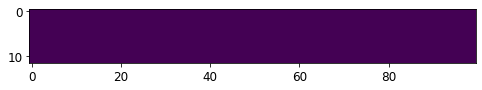

In [28]:
lat_data_debug = torch.cat([lat.unsqueeze(-1) for
                           lat in sim_lats], dim=2).cpu().numpy()
lat_data_single_batch = lat_data_debug[1,:,:]
plt.imshow(np.isnan(lat_data_single_batch));

In [29]:
#plt.plot(lat_data_single_batch[10,0:10])
print('tau1') # dt1
print(lat_data_single_batch[0,0:8]) # dt1
print('tau2') # dt2
print(lat_data_single_batch[1,0:8]) # dt2 == 0 
print('tau3') # dt3
print(lat_data_single_batch[2,0:8]) # dt3
print('tau4') # dt4
print(lat_data_single_batch[3,0:8]) # dt4
print('dt1') # dt1
print(lat_data_single_batch[8,0:8]) # dt1
print('dt2') # dt2
print(lat_data_single_batch[9,0:8]) # dt2 == 0 
print('dt3') # dt3
print(lat_data_single_batch[10,0:8]) # dt3
print('dt4') # dt4
print(lat_data_single_batch[11,0:8]) # dt4
print('t1') # dt1
print(lat_data_single_batch[4,0:8]) # dt1
print('t2') # dt2
print(lat_data_single_batch[5,0:8]) # dt2 == 0 
print('t3') # dt3
print(lat_data_single_batch[6,0:8]) # dt3
print('t4') # dt4
print(lat_data_single_batch[7,0:8]) # dt4
print('dt1') # dt1
print(lat_data_single_batch[8,0:8]) # dt1
print('dt2') # dt2
print(lat_data_single_batch[9,0:8]) # dt2 == 0 
print('dt3') # dt3
print(lat_data_single_batch[10,0:8]) # dt3
print('dt4') # dt4
print(lat_data_single_batch[11,0:8]) # dt4

tau1
[1.2270685  0.56945119 0.93948041 1.07426915 0.72465401 1.75329762
 0.72053951 0.64317329]
tau2
[-0.14150092 -0.27074824 -0.54317302 -0.83589687 -0.96418183 -0.99082767
 -0.40619467 -0.1917599 ]
tau3
[0.85336473 0.76639873 1.45865995 0.77857078 0.28939939 0.11866791
 0.28267161 0.10996467]
tau4
[0.56163878 0.51614672 0.63359462 1.22900876 2.25182346 1.63603289
 1.27477655 0.99046497]
dt1
[ 0.11605505  0.19084963  0.09112289 -0.23395224 -0.38015063 -0.58469455
 -0.47814566 -0.48436627]
dt2
[0.53097196 0.60076237 0.60183235 0.64024283 0.52104161 0.3410918
 0.22290509 0.1297822 ]
dt3
[-1.13303041 -0.04109747  1.25805144  3.98639002  5.50056249  5.86192774
  5.55585282  5.79465773]
dt4
[-0.1390858   0.07848905  0.25870795  0.54544279  1.06007538  2.03020469
  2.61074528  3.10472753]
t1
[-0.53247183 -0.6082959  -0.62765271 -0.5589225  -0.57402095 -0.60207644
 -0.62449573 -0.64127557]
t2
[-0.83765828 -0.76140973 -0.7052045  -0.71096007 -0.71742193 -0.69464111
 -0.69757529 -0.6884097 ]
t

In [34]:
# if simulating from a deterministic model (sympy notebook)
# should be (batch_size, dim_variable, num_timesteps)
if fit_to_hand_engineered_dataset:
    sim_lats = []
    sim_observs = []
    for i in range(sim_data_obj["sim_states"].shape[1]):
        sim_lats.append(
            torch.tensor(sim_data_obj["sim_states"][:, i]).expand(
                batch_size, sim_data_obj["sim_states"].shape[0]))
        sim_observs.append(torch.tensor(sim_data_obj["sim_obs"][:, i]).expand(
                batch_size, sim_data_obj["sim_obs"].shape[0]).to("cuda" if torch.cuda.is_available() else "cpu"))
    print(sim_lats[-1].shape)
    print(sim_observs[-1].shape)

torch.Size([64, 12])
torch.Size([64, 9])


In [29]:
# # if simulating from a deterministic model (TODO -- unify this cell and the above)
# sim_lats , sim_observs = fw_sim_planar_arm_dyn(
# sim_data(dt, num_timepoints, 
#                  param_dict, inits_dict, 
#                  sin_amp, sin_omega,
#                  sin_phase_diff, plot = True)  
# )
# print(sim_lats[-1].size()) # [batch_size, dim_latents]
# print(sim_observs[-1].size()) # [batch_size, dim_obs]

In [27]:
# concatenate and convert to numpy; for plotting.
lat_data = torch.cat([lat.unsqueeze(-1) for
                           lat in sim_lats], dim=2)
print(lat_data.shape) # [batch_size, dim_latents, num_timesteps]
sim_data = torch.cat([obs.unsqueeze(-1) for
                           obs in sim_observs], dim=2)
print(sim_data.shape)

if torch.cuda.is_available():
    lat_data_np = lat_data.detach().cpu().numpy()
    sim_data_np = sim_data.detach().cpu().numpy()
else:
    lat_data_np = lat_data.detach().numpy()
    sim_data_np = sim_data.detach().numpy()


torch.Size([256, 12, 100])
torch.Size([256, 9, 100])


In [28]:
# labels for plots.
label_dict_full = {}
label_dict_full["state"] = [r'$\tau_1$', r'$\tau_2$', 
                r'$\tau_3$', r'$\tau_4$',
              r'$\theta_1$', r'$\theta_2$',
              r'$\theta_3$', r'$\theta_4$',
             r'$\dot{\theta}_1$', r'$\dot{\theta}_2$',
            r'$\dot{\theta}_3$', r'$\dot{\theta}_4$']
label_dict_full["obs"] = [r'$x_0$', r'$y_0$', r'$z_0$',
                     r'$x_1$', r'$y_1$', r'$z_1$',
                  r'$x_2$', r'$y_2$', r'$z_2$']

In [29]:
for t in range(sim_data_np.shape[-1]):
    print('time: %i' % t)
    print('sim_data')
    print('Any None: %i' % np.isnan(sim_data_np[:,:,t]).any())
    print('None count: %i' %np.sum(np.isnan(sim_data_np[:,:,t])))
    print('Max. Val: %.2f' % np.nanmax(sim_data_np[:,:,t]))
    print('Min. Val: %.2f' %np.nanmin(sim_data_np[:,:,t]))
    print('sim latents')
    print('Any None: %i' % np.isnan(lat_data_np[:,:,t]).any())
    print('None count: %i' %np.sum(np.isnan(lat_data_np[:,:,t])))
    print('Max. Val: %.2f' %np.nanmax(lat_data_np[:,:,t]))
    print('Min. Val: %.2f' %np.nanmin(lat_data_np[:,:,t]))

time: 0
sim_data
Any None: 0
None count: 0
Max. Val: 1.91
Min. Val: -0.08
sim latents
Any None: 0
None count: 0
Max. Val: 0.13
Min. Val: -0.23
time: 1
sim_data
Any None: 0
None count: 0
Max. Val: 1.98
Min. Val: -0.05
sim latents
Any None: 0
None count: 0
Max. Val: 0.10
Min. Val: -0.23
time: 2
sim_data
Any None: 0
None count: 0
Max. Val: 1.93
Min. Val: -0.22
sim latents
Any None: 0
None count: 0
Max. Val: 0.11
Min. Val: -0.35
time: 3
sim_data
Any None: 0
None count: 0
Max. Val: 1.83
Min. Val: -0.17
sim latents
Any None: 0
None count: 0
Max. Val: 0.16
Min. Val: -0.60
time: 4
sim_data
Any None: 0
None count: 0
Max. Val: 2.14
Min. Val: -0.05
sim latents
Any None: 0
None count: 0
Max. Val: 0.23
Min. Val: -0.84
time: 5
sim_data
Any None: 0
None count: 0
Max. Val: 1.54
Min. Val: -0.33
sim latents
Any None: 0
None count: 0
Max. Val: 0.30
Min. Val: -1.08
time: 6
sim_data
Any None: 0
None count: 0
Max. Val: 1.90
Min. Val: -0.14
sim latents
Any None: 0
None count: 0
Max. Val: 0.37
Min. Val: -1.32

In [35]:
arm_model_instance.D_list[23].shape

(1, 4, 4)

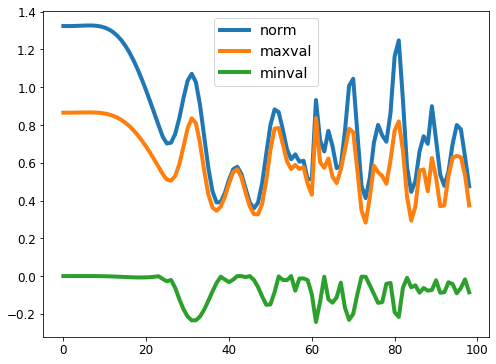

In [41]:
norms = np.zeros(len(arm_model_instance.D_list))
max_vals = np.zeros_like(norms)
min_vals = np.zeros_like(norms)
for i in range(len(arm_model_instance.D_list)):
    norms[i] = np.linalg.norm(arm_model_instance.D_list[i][0,:,:])
    max_vals[i] = np.max(arm_model_instance.D_list[i][0,:,:])
    min_vals[i] = np.min(arm_model_instance.D_list[i][0,:,:])

plt.plot(norms, label = 'norm')
plt.plot(max_vals, label = 'maxval')
plt.plot(min_vals, label = 'minval')
plt.legend()

(array([ 6,  6,  6,  6,  6,  6,  6,  7,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11]), array([89, 91, 92, 93, 94, 98, 99,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,  2, 23, 24, 25, 26, 27,
       28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
       45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
       62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
       79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 95, 96, 97,  0]))


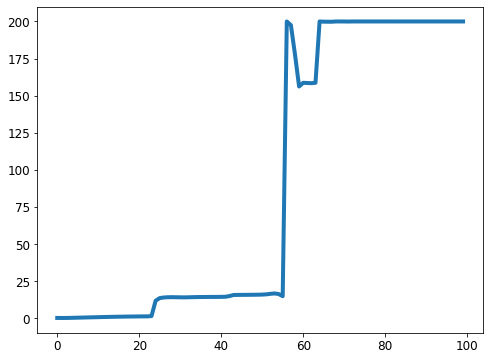

In [33]:
#print(full_model["transition"].diag_mat)
np.nanmax(lat_data_np[0,:,:], axis=0).shape
plt.plot(np.nanmax(lat_data_np[0,:,:], axis=0))
print(np.where(lat_data_np[0,:,:] == np.nanmax(lat_data_np[0,:,:], axis=0)))

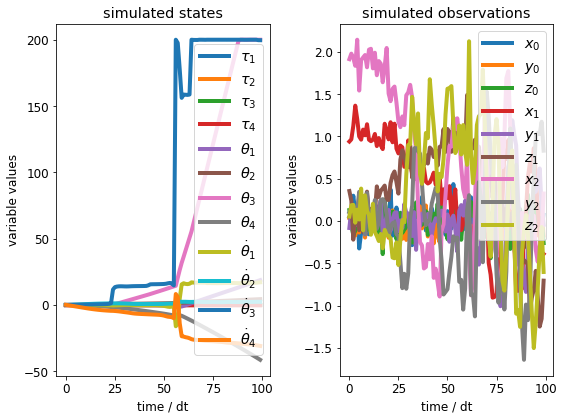

In [31]:
ind_in_batch = 1
plot_simulated_data(lat_data_np, 
                        sim_data_np, 
                        ind_in_batch,
                        label_dict_full,
                       plot_folder + '/sim_dataset.png')

In [28]:
from scipy.special import logsumexp

In [29]:
inference_result = infer_latents(full_model, 
                                 sim_observs, 
                                 num_particles)

run time for 100 timesteps, 256 batches, 1000 particles = 13.81


In [30]:
keys = inference_result.keys()
for key in keys:
    #print(key)
    if type(inference_result[key]) is torch.Tensor:
        inference_result[key] = inference_result[key].cpu()
    elif type(inference_result[key]) is list:
        if len(inference_result[key]) > 0:
            for i in range(len(inference_result[key])):
                inference_result[key][i] = inference_result[key][i].cpu()

In [31]:
# summarize posterior separately for each batch element.
# if batches are identical, each includes an independent SMC sample
posterior_summary = utils_summary.summarize_posterior(inference_result)

applying uniform average of 256 SMC samplers.
applying weighted average of 256 SMC samplers.


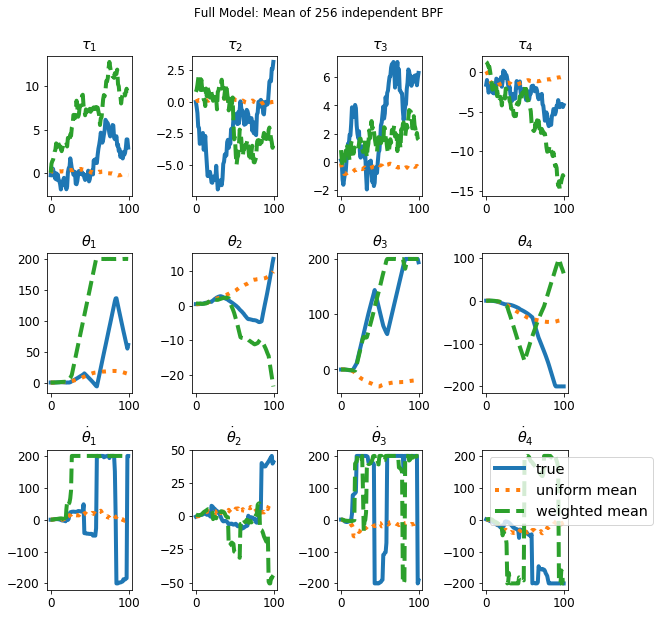

In [32]:
# comparison of uniform and weighted means
# uniform:
mean, var = utils_summary.summarize_independent_smc_samplers(
    posterior_summary["smooth_mean"],
    posterior_summary["smooth_var"],
    logw=None,
    method='uniform')
# weighted:
weighted_mean, weighted_var = utils_summary.summarize_independent_smc_samplers(
    posterior_summary["smooth_mean"],
    posterior_summary["smooth_var"],
    logw=inference_result["log_marginal_likelihood"].detach().numpy(),
    method='weighted',
    remove_indices=None)  # typically better to remove 1/2 dominating indices

# plot the two estimates.
f, axarr = plt.subplots(3, 4, figsize=(9, 9))
axarr = axarr.flatten()
for i in range(lat_data_np.shape[1]):
    axarr[i].plot(lat_data_np[0, i, :], label='true')
    axarr[i].plot(mean[i, :], linestyle='dotted', label='uniform mean')
    axarr[i].plot(weighted_mean[i, :],
                  linestyle='dashed',
                  label='weighted mean')
    axarr[i].set_title(label_dict_full["state"][i])
    if i == lat_data_np.shape[1] - 1:
        plt.legend()
f.suptitle('Full Model: Mean of %i independent BPF' % batch_size)
f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(plot_folder + '/mean_of_64_filters.png')

In [35]:
print(weighted_mean[4,0:50])

[  0.32237513   0.36408336   0.35853135   0.38266317   0.40712335
   0.51729641   0.52847395   0.57524063   0.59500202   0.66727658
   0.72180352   0.81144117   0.93776761   1.12229461   1.25808247
   1.35279455   1.39940961   1.52506195   1.58912686   1.39050132
   1.07110588   2.05799633   3.74465912   5.0437727    6.57750456
   8.19421991  10.1709338   12.85706603  18.89883161  24.93684283
  30.92205043  36.97133933  43.04364275  49.14304659  55.18667355
  61.15100182  67.11627593  73.17790563  79.16080397  85.1675646
  91.15750281  97.21198935 103.20350462 109.20063812 115.14674196
 121.13429311 127.13294849 133.10816238 139.1925715  145.15228126]


independent SMC ESS: 1
(array([46]),)


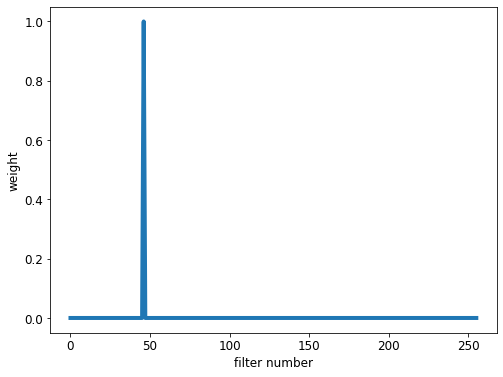

In [33]:
from scipy.special import logsumexp
logw = inference_result["log_marginal_likelihood"].detach().numpy()
w = np.exp(logw - logsumexp(logw))
plt.plot(w)
independent_SMC_ESS = 1.0 / np.sum(w**2)
print('independent SMC ESS: %d' % independent_SMC_ESS)
print(np.where(w==np.max(w)))
plt.ylabel('weight')
plt.xlabel('filter number')
plt.savefig(plot_folder + '/weights_ind_smc.png')

In [42]:
#np.sort(w) # note that many some w's are == 0. check that in future.

In [43]:
#np.where(w==0)
#np.where(np.isin(w, np.sort(w)[-2:])) # which are the two best filters
#np.where(~np.isin(w, np.sort(w)[-2:])) # worst filters

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt


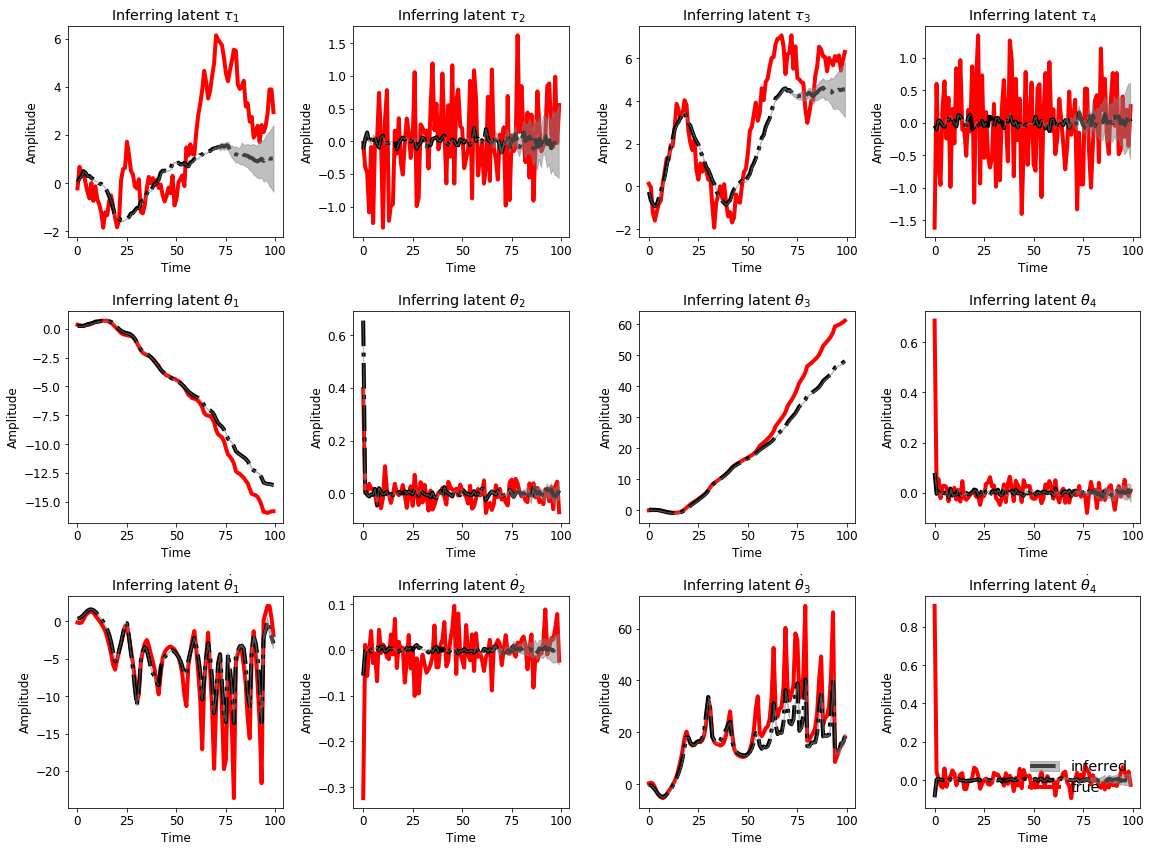

In [44]:
# another version of the plot, incorporating variances.
fig_full_path = plot_folder + '/uniform.png'
nrows = 3
num_latents = lat_data_np.shape[1]
fig, axs = plt.subplots(nrows,
                        int(num_latents / nrows),
                        figsize=(16, 12),
                        sharey=False)
axs = axs.flatten()
plt_leg = False
for i in range(mean.shape[0]):
    if i == num_latents-1:
        plt_leg = True
    arm_utils.plot_posterior_trace(
    post_mean=mean[i,:],
    post_var=np.sqrt(var[i,:]),
    data_vec=lat_data_np[ind_in_batch, i, :],
    alpha=0.5,
    plot_legend=plt_leg,
    plot_uncertainty=True,
    plot_true_data=True,
    legends_list=["inferred", "true"],
    legend_loc="lower right",
    title="Inferring latent " + label_dict_full["state"][i],
    xlabel='Time',
    ylabel='Amplitude',
    fig_fullname=None,
    ax=axs[i])
fig.tight_layout()
plt.savefig(fig_full_path)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered 

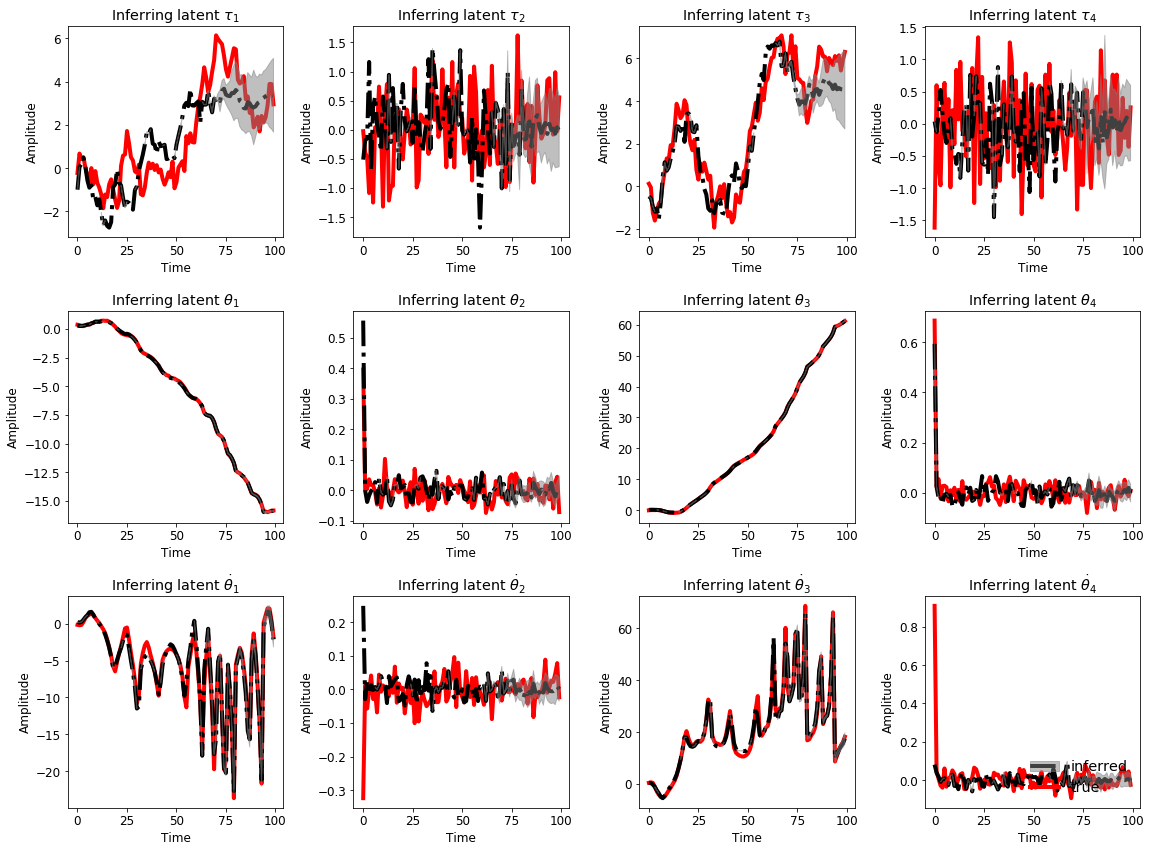

In [45]:
# another version of the plot, incorporating variances.
fig_full_path = plot_folder + '/weighted.png'
nrows = 3
num_latents = lat_data_np.shape[1]
fig, axs = plt.subplots(nrows,
                        int(num_latents / nrows),
                        figsize=(16, 12),
                        sharey=False)
axs = axs.flatten()
plt_leg = False
for i in range(weighted_mean.shape[0]):
    if i == num_latents-1:
        plt_leg = True
    arm_utils.plot_posterior_trace(
    post_mean=weighted_mean[i,:],
    post_var=np.sqrt(weighted_var[i,:]),
    data_vec=lat_data_np[ind_in_batch, i, :],
    alpha=0.5,
    plot_legend=plt_leg,
    plot_uncertainty=True,
    plot_true_data=True,
    legends_list=["inferred", "true"],
    legend_loc="lower right",
    title="Inferring latent " + label_dict_full["state"][i],
    xlabel='Time',
    ylabel='Amplitude',
    fig_fullname=None,
    ax=axs[i])
fig.tight_layout()
plt.savefig(fig_full_path)

In [83]:
logw = inference_result["log_marginal_likelihood"].detach().numpy()
from scipy.special import logsumexp
w = np.exp(logw - logsumexp(logw))
independent_SMC_ESS = 1.0 / np.sum(w**2)

1.0

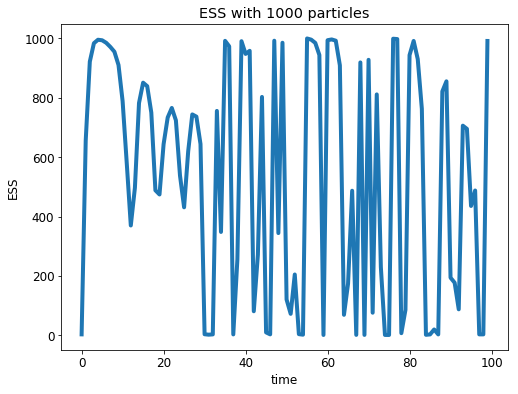

In [80]:
# plot ESS
ind_in_batch = 40
plt.plot(posterior_summary["ESS"][ind_in_batch,:])
plt.xlabel('time')
plt.ylabel('ESS')
plt.title('ESS with %i particles' % num_particles);
plt.savefig(plot_folder+'/ESS_1.png')

Evaluate log joint of true data and inferred means:
$$
\log{}p(x,y) = \sum_{t}^{T} [ \log{}p(x_{t}|x_{t-1}) + \log{}p(y_{t}|x_{t})]
$$
which can be evaluated either for the simulated $x_t$ or for $\hat{x}_t : = \mathbb{E}_{p(x_t | y_{1:T})}[x_t]$

In [67]:
def compute_log_joint(full_model, latents, observations):
    '''
    loop over time points and compute p(x,y)
    Args: 
        full_model: dict with keys "initial", "transition", and "emission" which are torch.Distribution objects
        latents: list of len num_timesteps with torch.size(batch_size, dim_latent). no particle dim.
        observations: list of len num_timesteps with torch.size(batch_size, dim_observs). no particle dim.
    Returns: scalar, log joint, for each element in the batch dimension, so torch.size(batch_size)
    '''
    inst_log_joint = []
    for i in range(len(sim_observs)):
        if i == 0:
            log_trans = full_model["initial"]().log_prob(
                latents[0].unsqueeze(1))
        else:
            log_trans = full_model["transition"](
                previous_latents=[latents[i - 1].unsqueeze(1)]).log_prob(
                    latents[i].unsqueeze(1))
        log_emission = full_model["emission"](
            latents=[latents[i].unsqueeze(1)]).log_prob(
                sim_observs[i].unsqueeze(1))

        inst_log_joint.append(
            log_trans + log_emission
        )  # eventually, list with len num_timesteps, each element torch.size([batch_size,1])

    # list of tensors -> tensor of torch.size([num_timesteps, batch_size])
    temp = torch.stack(inst_log_joint,
                       dim=0).squeeze(-1)  # get rid of the particle dim
    # sum across num_timesteps to get tensor of torch.Size([batch_size])
    log_joint = torch.sum(temp, dim=0)

    return log_joint

In [68]:
# ToDo: should re implement inferred_mean_list (deleted somehow!). loop over the inferred means and make them into a list.
log_joint_true = compute_log_joint(full_model, sim_lats, sim_observs)
log_joint_inferred = compute_log_joint(full_model, inferred_mean_list, sim_observs)

NameError: name 'inferred_mean_list' is not defined

In [69]:
plot_folder + '/log_joints.png'

'3d_arm_dyn_plots/log_joints.png'

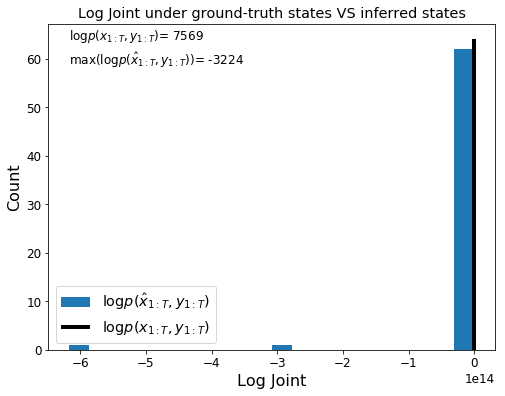

In [315]:
plt.hist(log_joint_inferred.numpy(), bins = 20, label = r'$\log{}p(\hat{x}_{1:T},y_{1:T})$')
plt.vlines(ymin = 0, ymax = batch_size, x=log_joint_true.numpy()[-1], label = r'$\log{}p(x_{1:T},y_{1:T})$')
plt.xlabel('Log Joint', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.legend(loc = 'lower left')
plt.title('Log Joint under ground-truth states VS inferred states');
text_str_true = r'$\log{}p(x_{1:T},y_{1:T})$' + '= %d' % log_joint_true.numpy()[-1]
text_str_inferred = r'$\max{}(\log{}p(\hat{x}_{1:T},y_{1:T}))$' + '= %d' % np.max(log_joint_inferred.numpy()) 
plt.text(y=batch_size, x = np.min(log_joint_inferred.numpy()),  s=text_str)
plt.text(y=batch_size-5, x = np.min(log_joint_inferred.numpy()),  s=text_str_inferred)
plt.savefig(plot_folder + '/log_joints.png')


In [304]:
print(np.max(log_joint_inferred.numpy()))
print(log_joint_true.numpy()[-1])

-3224.6295206919212
7569.46672232599


In [37]:
## if simulate all the way forward to coords.
#x_obs = sim_data_np[ind_in_batch, [0,2,4], :].T
#y_obs = sim_data_np[ind_in_batch, [1,3,5], :].T
## if simulate only to angles and velocities.
x_obs, y_obs = arm_utils.coords_from_params_mat(
   lat_data_np[ind_in_batch,2,:], 
    lat_data_np[ind_in_batch,3,:], 
                inits_dict["L1"], inits_dict["L2"]) 
print(y_obs.shape)

(200, 3)


In [38]:
# TODO: make sure to input right params for learning
# this is the version for weighted average of BPFs
x_hat , y_hat = arm_utils.coords_from_params_mat(
   weighted_mean[2,:], 
    weighted_mean[3,:], 
                inits_dict["L1"], inits_dict["L2"]) 
x_hat.shape

(200, 3)

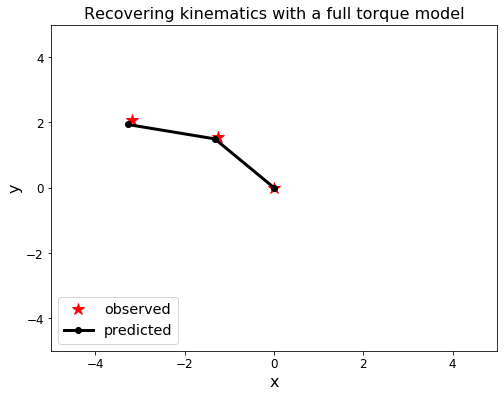

In [39]:
arm_utils.video_sim_plane_2D(x_obs, y_obs, 
                             x_hat, y_hat, 
                             plot_folder+'/recover_dyn', 
                   "Recovering kinematics with a full torque model", 
                             x_hat.shape[0], inits_dict["L1"] + 
                             inits_dict["L2"] + 1)

In [30]:
# tested with functions. it works.
# ToDo: consider building a class that does that.
# give it the inference results and desired K realizations and it'll
# do everything.

k_realizations = 50
smoothing_result = {}  # dict of lists
smoothing_result["normalized_weights"] = []
smoothing_result["latents"] = []
smoothing_result["sampled_indices"] = []

for t in range(num_timesteps - 1, -1, -1):
    if t == num_timesteps - 1:
        normalized_weights = smoothing.expand_normalize_weights(
            inference_result["log_weights"][-1],
            k_realizations)  # Note index -1
        sampled_indices, latents = smoothing.sample_latents(
            normalized_weights, inference_result["latents"][-1])
    else:
        # compute weights
        normalized_weights = smoothing.weight_update(latents,
                                           inference_result["latents"][t],
                                           inference_result["log_weights"][t],
                                           full_model["transition"])

        sampled_indices, latents = smoothing.sample_latents(
            normalized_weights, inference_result["latents"][t])

    # these lists will all be flipped in time
    smoothing_result["normalized_weights"].append(normalized_weights)
    smoothing_result["latents"].append(latents)
    smoothing_result["sampled_indices"].append(sampled_indices)

In [31]:
# flip order
smoothing_result["normalized_weights"] = smoothing_result["normalized_weights"][::-1]
smoothing_result["latents"] = smoothing_result["latents"][::-1]
smoothing_result["sampled_indices"] = smoothing_result["sampled_indices"][::-1]

In [32]:
smoothing_result["latents"][-1].shape
posterior_summary["smooth_mean"].shape

(16, 6, 200)

In [33]:
smooth_traj = torch.cat(
    [smooth.unsqueeze(-1) for smooth in smoothing_result["latents"]], dim=3)
smooth_mean = torch.mean(smooth_traj,
                         dim=0).detach().numpy()  # over trajectories
smooth_var = torch.var(smooth_traj, dim=0).detach().numpy()

In [34]:
smooth_mean.shape
smooth_var.shape

(16, 6, 200)

In [35]:
# if batch elements are identical, take a uniform mean
mean, var = summarize_independent_smc_samplers(
    smooth_mean,
    smooth_var,
    logw=None,
    method='uniform')

applying uniform average of 16 SMC samplers.


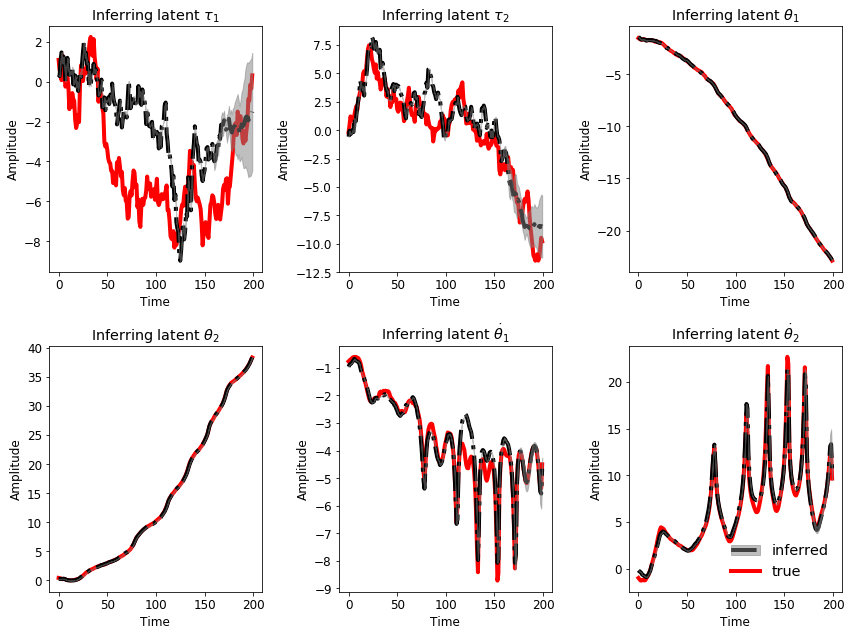

In [36]:
ind_in_batch = 6  # just one batch
fig, axs = plt.subplots(2, 3, figsize=(12, 9), sharey=False)
axs = axs.flatten()
plt_leg = False
for i in range(posterior_summary["smooth_mean"].shape[1]):
    if i == 5:
        plt_leg = True
    arm_utils.plot_posterior_trace(
        post_mean=smooth_mean[ind_in_batch, i, :],
        post_var=np.sqrt(smooth_var[ind_in_batch, i, :]),
        data_vec=lat_data_np[ind_in_batch, i, :],
        alpha=0.5,
        plot_legend=plt_leg,
        plot_uncertainty=True,
        plot_true_data=True,
        legends_list=["inferred", "true"],
        legend_loc="lower right",
        title="Inferring latent " + label_dict_full["state"][i],
        xlabel='Time',
        ylabel='Amplitude',
        fig_fullname=None,
        ax=axs[i])
fig.tight_layout()
plt.savefig(plot_folder + '/FFBS_BPF_infer_latents.png')

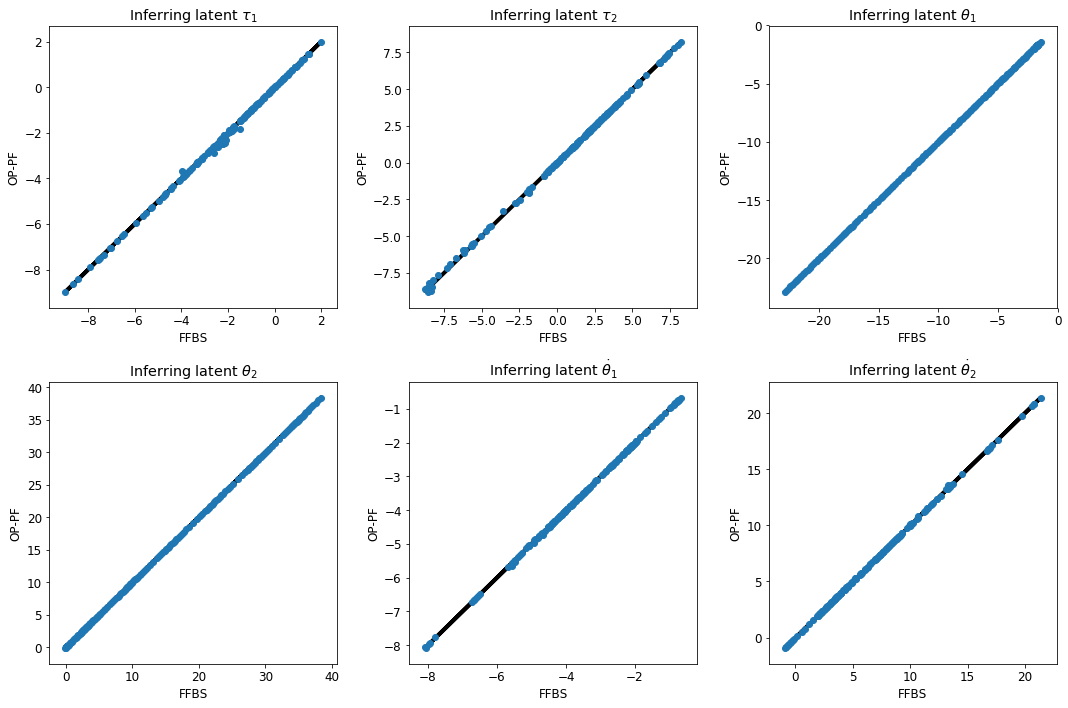

In [38]:
titles = ['$x_{1}$', '$x_{2}$']
plt_leg = False
nrows = 2
fig, axs = plt.subplots(nrows,int(posterior_summary["smooth_mean"].shape[1]/nrows), 
                        figsize = (15,10), sharey=False)
axs = axs.flatten()
for i in range(posterior_summary["smooth_mean"].shape[1]):
    
    if i == 0:
        label = '$x_{1} = f$'
    elif i == 1:
        label = '$x_{2} = x$'
    elif i == 2:
        label = '$x_{3} = \dot{x}$'
        plt_leg = True
    
    axs[i].plot(smooth_mean[ind_in_batch,i,:], 
                smooth_mean[ind_in_batch,i,:], 'k') # diag line
    axs[i].scatter(smooth_mean[ind_in_batch,i,:], 
            posterior_summary["smooth_mean"][ind_in_batch,i,:], 
                   zorder=3)
    axs[i].set_xlabel('FFBS')
    axs[i].set_ylabel('OP-PF')
#     axs[i].plot(filtered_state_means[:,i], color = 'black', linestyle = 'dotted', 
#                 label = 'Kalman filter');
    axs[i].set_title("Inferring latent " +  label_dict_full["state"][i])

fig.tight_layout()
plt.savefig(plot_folder+'/compare_FFBS_BPF.png')

Implement learning of $M_1$ and $M_2$

In [29]:
sim_data_np.shape

(16, 6, 200)

In [35]:
sim_data_np[0, :2, :]

array([[ 5.70418582e-02, -1.26147187e-01,  7.33463124e-02,
        -1.06593631e-03,  2.47888052e-02, -2.22029565e-01,
        -8.18543951e-02, -2.51541028e-01, -8.01100919e-02,
        -2.31288582e-02, -7.02392525e-02, -1.77268907e-01,
         2.89053106e-01,  1.63828490e-02, -1.90669266e-01,
         7.54882909e-02,  1.19438432e-01,  2.13900395e-02,
         3.19796050e-02,  1.90996601e-01,  1.32161615e-01,
         1.18693354e-01,  4.96322846e-02, -5.77234386e-02,
         5.99473435e-02, -7.47436410e-02, -3.49145487e-01,
         3.36627451e-01,  2.93188017e-02,  1.38095598e-01,
         7.88760159e-02, -1.46822371e-02, -1.35461429e-01,
         3.88674974e-01,  1.61835988e-01, -8.74782858e-02,
         1.82245095e-01, -1.15807996e-01, -1.59490798e-01,
        -1.74081084e-01,  2.35196582e-01,  1.15926201e-04,
        -3.71860548e-02,  2.13730724e-01, -3.26950107e-01,
        -1.16073656e-01, -1.65290985e-01, -5.48096284e-02,
        -1.08871898e-01, -2.64580158e-01, -7.58570321e-0

In [44]:
empirical_estimate_L1 = np.linalg.norm(sim_data_np[0, 2:4, :] - sim_data_np[0, :2, :], axis=0)
empirical_estimate_L2 = np.linalg.norm(sim_data_np[0, 4:, :] - sim_data_np[0, 2:4, :], axis=0)

In [48]:
(inits_dict["L1"] - np.median(empirical_estimate_L1)) / inits_dict["L1"]

-0.003617780302634266

In [49]:
(inits_dict["L2"] - np.median(empirical_estimate_L2)) / inits_dict["L2"]

-0.009406472491689799

In [52]:
# look at fw kin learning script for variables, etc.

2.0

In [22]:
learning_arm_params = False
if learning_arm_params:
    learning_inits_dict = {}
    learning_inits_dict['L1'] = inits_dict["L1"] + 0.5 # for now, can be empirical estimate or learned
    learning_inits_dict['L2'] = inits_dict["L1"] - 0.5 # same
    learning_inits_dict['M1'] = inits_dict["M1"] - 0.6 # test init for true == 1.1
    learning_inits_dict['M2'] = inits_dict["M2"] + 0.7 # test init for true == 1.1
else:
    learning_inits_dict = inits_dict
print(learning_inits_dict)

{'L1': 1.0, 'L2': 1.0, 'M1': 0.25, 'M2': 0.3}


In [23]:
arm_model_learning = arm_3d_dyn_model.Arm_3D_Dyn(
    dt=dt,
    inits_dict=inits_dict,
    g=g,
    include_gravity_fictitious=True,
    transform_torques=False,
    learn_static=learning_arm_params,
    restrict_to_plane=True) # Remove True in full model!

In [24]:
list(arm_model_learning.parameters())

[Parameter containing:
 tensor(1.),
 Parameter containing:
 tensor(1.),
 Parameter containing:
 tensor(0.2500),
 Parameter containing:
 tensor(0.3000)]

In [25]:
param_dict
# ToDo: there are more params you can add to param dict?

{'init_mu': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'init_cov': array([[0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5]])}

In [26]:
learning_model = {}
'''full_model includes arm dynamics, and FW-KIN emission.
here we learn M1 and M2'''

learning_model["initial"] = arm_3d_dyn_model.Initial(param_dict["init_mu"],
                                                     param_dict["init_cov"])

learning_model["transition"] = arm_3d_dyn_model.Transition(
    dt, transition_force_scale, transition_aux_scale, arm_model_learning)

learning_model["emission"] = arm_3d_dyn_model.Emission(inits_dict, #ToDo: inits_dict is now redundant for L1,L2
                                                       np.eye(9) *
                                                       emission_var_diag,
                                                       arm_model_learning,
                                                       theta_indices=[4,5,6,7])

learning_model["proposal"] = arm_3d_dyn_model.Learned_Proposal( \
                               learning_model["initial"], 
                                learning_model["transition"],
                                20)

In [27]:
num_timesteps

100

In [28]:
# running params
num_timesteps = 100
saving_interval = 10
logging_interval = 1
batch_size = 64 # 64 is good for independent SMC. the higher the better.
num_iterations = 10
num_particles = 500
num_epochs = 100

In [44]:
dataloader = train.get_synthetic_dataloader(
            full_model["initial"],
            full_model["transition"],
            full_model["emission"],
            num_timesteps, batch_size)

In [36]:
# ToDo: look at the aesmc original script for training
training_stats = arm_3d_dyn_model.TrainingStats(true_inits_dict=inits_dict,
                arm_model_instance = arm_model_learning,
                num_timesteps = num_timesteps,
                logging_interval = logging_interval)

In [29]:
arm_model_learning.to("cuda" if torch.cuda.is_available() else "cpu")

Arm_3D_Dyn()

In [30]:
# # just for now, but should be set . no need to run. can change defs here
# for param in list(arm_model_learning.parameters()):
#     parm.requires_grad = True
# print(list(arm_model_learning.parameters()))

In [31]:
from scipy.special import logsumexp

In [32]:
import itertools

def get_chained_params(*objects):
    result = []
    for object in objects:
        if (object is not None) and isinstance(object, nn.Module):
            result = itertools.chain(result, object.parameters())

    if isinstance(result, list):
        return None
    else:
        return result
    
def train_single_dataset(observations, num_particles, algorithm, initial, transition, emission,
          proposal, num_epochs, num_iterations_per_epoch=None,
          optimizer_algorithm=torch.optim.Adam, optimizer_kwargs={},
          callback=None):
    
    parameters = get_chained_params(initial, transition, emission, proposal)
    optimizer = optimizer_algorithm(parameters, **optimizer_kwargs)
    for epoch_idx in range(num_epochs):
        if torch.sum(torch.isnan(torch.cat(observations)))>0:
                continue
        optimizer.zero_grad()
        loss = losses.get_loss(observations, num_particles, algorithm,
                               initial, transition, emission, proposal)
        loss.backward()
        optimizer.step()
        
        print(loss.cpu().numpy())

In [37]:
train_single_dataset(observations = sim_observs,
            num_particles=num_particles,
            algorithm='aesmc',
            initial=learning_model["initial"],
            transition=learning_model["transition"],
            emission=learning_model["emission"],
            proposal=learning_model["proposal"],
            num_epochs=num_epochs,
            num_iterations_per_epoch=num_iterations,
            callback=None)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 15.78 GiB total capacity; 14.35 GiB already allocated; 10.44 MiB free; 14.69 GiB reserved in total by PyTorch)

In [49]:
train.train(dataloader=dataloader,
            num_particles=num_particles,
            algorithm='aesmc',
            initial=learning_model["initial"],
            transition=learning_model["transition"],
            emission=learning_model["emission"],
            proposal=learning_model["proposal"],
            num_epochs=num_epochs,
            num_iterations_per_epoch=num_iterations,
            callback=training_stats)

each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.


KeyboardInterrupt: 

In [39]:
#np.sum(np.isnan(torch.cat(sim_observs).cpu().numpy()))
#torch.cat(sim_observs).shape
assert(torch.sum(torch.isnan(torch.rand(10,10)))==0 & torch.sum(torch.isnan(torch.rand(12,10)))==0)

TypeError: unsupported operand type(s) for &: 'int' and 'Tensor'

In [50]:
# debug nans in the data
num_iterations_per_epoch = num_iterations
for epoch_idx in range(num_epochs):
    torch.manual_seed(0) # to make sure data loader repeats batches across epochs.
    for epoch_iteration_idx, observations in enumerate(dataloader):
        nan_counts = np.sum(np.isnan(torch.cat(observations).cpu().numpy()))
        if nan_counts>0:
            print(nan_counts)
        if num_iterations_per_epoch is not None:
            if epoch_iteration_idx == num_iterations_per_epoch:
                break

each batch contains different data.
240
each batch contains different data.
198
each batch contains different data.
252
each batch contains different data.
252
each batch contains different data.
306
each batch contains different data.
162
each batch contains different data.
210
each batch contains different data.
198
each batch contains different data.
102
each batch contains different data.
264
each batch contains different data.
198
each batch contains different data.
240
each batch contains different data.
198
each batch contains different data.
252
each batch contains different data.
252
each batch contains different data.
306
each batch contains different data.
162
each batch contains different data.
210
each batch contains different data.
198
each batch contains different data.


KeyboardInterrupt: 

In [35]:
for i in range(4):
    if i==2:
        continue
    print(i)

0
1
3


In [33]:
training_stats.curr_params_list

[array([2.49700022, 1.49699986, 0.49700004, 1.89699984]),
 array([2.49400926, 1.49793363, 0.4989669 , 1.89731312]),
 array([2.49107742, 1.49938333, 0.50068009, 1.89818633]),
 array([2.488065  , 1.50084352, 0.50290495, 1.89820015]),
 array([2.4851253 , 1.50281751, 0.50551438, 1.90007496]),
 array([2.48240852, 1.50460708, 0.50689256, 1.90183008]),
 array([2.47966623, 1.50586808, 0.50735027, 1.90305948]),
 array([2.47681284, 1.50688112, 0.50774562, 1.90401912]),
 array([2.47378564, 1.50753689, 0.50755501, 1.90464509]),
 array([2.47074509, 1.50797939, 0.50734842, 1.90505576]),
 array([2.46790624, 1.50833714, 0.50741404, 1.90537548]),
 array([2.4668138 , 1.50765264, 0.50564218, 1.90488935]),
 array([2.4658637 , 1.50678515, 0.50434196, 1.90419471]),
 array([2.46639371, 1.50420797, 0.50180221, 1.90163028]),
 array([2.46706963, 1.50164759, 0.49926013, 1.8990767 ]),
 array([2.4672091 , 1.49973607, 0.49735665, 1.89717078]),
 array([2.4668169 , 1.49832559, 0.49593547, 1.89576614]),
 array([2.4659

In [36]:
learning_model["proposal"]

Learned_Proposal(
  (transition): Transition(
    (arm_model): Arm_3D_Dyn()
  )
  (FF_mu): Sequential(
    (0): Linear(in_features=9, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=12, bias=True)
  )
  (FF_var): Sequential(
    (0): Linear(in_features=9, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=12, bias=True)
    (3): Softplus(beta=1, threshold=20)
  )
)

In [34]:
params = np.asarray(training_stats.curr_params_list)
print(params)

[[2.49700022 1.49699986 0.49700004 1.89699984]
 [2.49400926 1.49793363 0.4989669  1.89731312]
 [2.49107742 1.49938333 0.50068009 1.89818633]
 ...
 [2.16396403 1.48020077 0.50613308 1.86156929]
 [2.16436934 1.4805733  0.50662583 1.86199868]
 [2.16406298 1.48040545 0.5069297  1.8618288 ]]


In [47]:
list(inits_dict.keys())[0]

'L1'

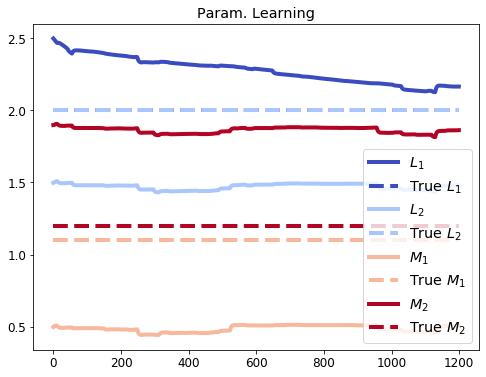

In [56]:
from matplotlib.pyplot import cm
param_label_list = [r"$L_1$", r"$L_2$", r"$M_1$", r"$M_2$"]
key_list = list(inits_dict.keys())
color=iter(cm.coolwarm(np.linspace(0,1,len(key_list))))
for i in range(params.shape[1]):
    c = next(color)
    plt.plot(params[:,i], label = param_label_list[i], c=c)
    plt.plot([0, len(params)], [inits_dict[key_list[i]], inits_dict[key_list[i]]], \
                                label = "True " + param_label_list[i],
            linestyle = "dashed", c=c)
plt.legend()
plt.title("Param. Learning")
plt.savefig(plot_folder + '/param_learning.png')

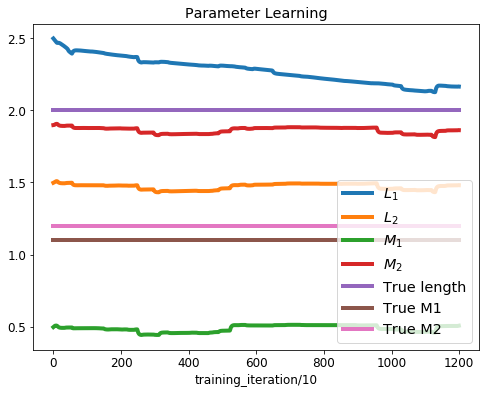

In [43]:
plt.title('Parameter Learning')
plt.plot(params[:,0], label = r"$L_1$")
plt.plot(params[:,1], label = r"$L_2$")
plt.plot(params[:,2], label = r"$M_1$")
plt.plot(params[:,3], label = r"$M_2$")
plt.plot([0, len(params)], [2.0, 2.0], label = "True length")
plt.plot([0, len(params)], [inits_dict["M1"], inits_dict["M1"]], label = "True M1")
plt.plot([0, len(params)], [inits_dict["M2"], inits_dict["M2"]], label = "True M2")

plt.xlabel('training_iteration/10')
plt.legend()

$M_1 : = 1, M_2 = \lambda \cdot M_1$ 
since we can init $L$ properly from observations, maybe fix $L$'s and $M_1$ -- can we infer $M_2$?
If this becomes hard, just fix all params and ignore the learning problem.

In [49]:
L1_in_training  = np.zeros(len(training_stats.curr_params_list))
L2_in_training  = np.zeros(len(training_stats.curr_params_list))

for i in range(len(training_stats.curr_params_list)):
    L1_in_training[i] = training_stats.curr_params_list[i][0]
    L2_in_training[i] = training_stats.curr_params_list[i][1]

NameError: name 'L1_in_training' is not defined

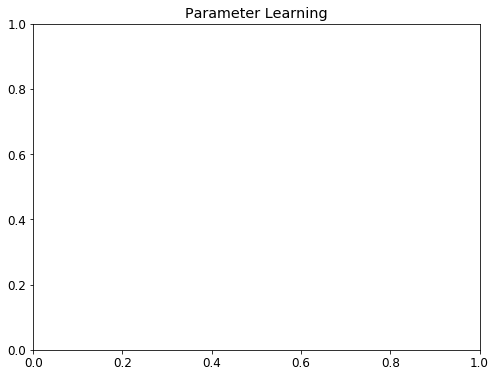

In [57]:
plt.title('Parameter Learning')
plt.plot(L1_in_training, label = r"$L_1$")
plt.plot(L2_in_training, label = r"$L_2$")
plt.plot([0, len(L1_in_training)], [2.0, 2.0], 'k', label = "True length")
plt.xlabel('training_iteration/10')
plt.legend()

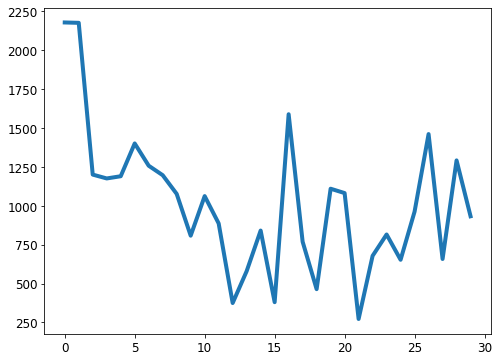

In [56]:
plt.plot(training_stats.loss)

In [61]:
list(arm_model_learning.parameters())

[Parameter containing:
 tensor(2.0476, device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor(1.9407, device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor(2., device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor(1.2000, device='cuda:0', requires_grad=True)]

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [62]:
learning_model["transition"].to(device)

Transition(
  (arm_model): PlanarArmDyn()
)

In [57]:
type(learning_model["transition"])

arm_models.planar_arm_dyn_model.Transition

In [64]:
learning_model["transition"].diag_mat.device

device(type='cpu')

In [65]:
torch.cuda.empty_cache()

In [70]:
list(learning_model["transition"].parameters())

[Parameter containing:
 tensor(0.7084, device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor(1.5079, device='cuda:0', requires_grad=True)]

In [69]:
learning_model["transition"].cuda()

Transition(
  (arm_model): PlanarArmDyn()
)

In [72]:
learning_model["transition"].diag_mat.to(device)

tensor([[0.3600, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3600, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0013, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0013, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0013, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0013]], device='cuda:0',
       dtype=torch.float64)

In [39]:
# # testing stuff
# fake_obs_for_debug = [torch.rand(batch_size, 9)]
# print(fake_obs_for_debug[0].shape)
# full_model["proposal"](observations = fake_obs_for_debug, time = 0)
# batched_identity_mat = torch.eye(dim_latents).unsqueeze(0).expand(batch_size, dim_latents,
#                                            dim_latents)
# print(batched_identity_mat.shape)
# # batched_identity_mat.matmul(out_test_sigma.unsqueeze(-1)).shape
# #out_test_sigma.matmul(batched_identity_mat).shape
# out1 = out_test_sigma.matmul(torch.eye(dim_latents))
# out1.shape
# print(out1[0,:])
# print(out_test_sigma[0,:])
# tens_test = torch.tensor([4.0, 5.0, 6.0])
# res1 = torch.diag(torch.tensor([1.0,2.0,3.0])).mm(tens_test.unsqueeze(-1))
# res2 = (torch.tensor([1.0,2.0,3.0]) * tens_test).unsqueeze(-1)
# print(res1)
# print(res2)
# print(res1==res2)
# print(1.0/res2)
# print(1.0/torch.diag(full_model["proposal"].cov_0))
# # # initial dist. params.
# n_hidden_units = 20


# sigma_squared_0 = torch.diag(full_model["initial"].cov_mat)
# one_over_sigma_squared_0 = 1.0/sigma_squared_0
# mu_0 = full_model["initial"].loc
# # print(sigma_squared_0, one_over_sigma_squared_0, mu_0 )
# # transition dist. params.
# sigma_squared_t = torch.diag(full_model["transition"].diag_mat)
# #one_over_sigma_squared_t = 1.0/sigma_squared_t

# # ToDo -- in future consider biderectional LSTM
# FF_mu = nn.Sequential(
#                 nn.Linear(9, n_hidden_units),
#                 nn.ReLU(),
#                 nn.Linear(n_hidden_units,12)) # observations[t] -> mu[t]

# FF_var = nn.Sequential(
#                 nn.Linear(9, 12),
#                 nn.Softplus()) # observations[t] -> sigma[t], TODO: consider clamping at say 10

# # at time == 0
# mu_star_0 = FF_mu(observations[0])
# sigma_squared_star_0 = FF_var(observations[0])
            
# proposed_precision_0 = 1.0/sigma_squared_0 + 1.0/sigma_squared_star_0
# proposed_sigma_squared_0 = 1.0/proposed_precision_0

# proposed_mu_0 = proposed_sigma_squared_0*((1.0/sigma_squared_0)*mu_0 +
#                                          1.0/sigma_squared_star_0*mu_star_0)
# # ToDo -- change bellow to aesmc.state in python
# distrib_0 = state.set_batch_shape_mode(
#                 torch.distributions.Normal(
#                     loc=proposed_mu_0,
#                     scale=torch.sqrt(proposed_sigma_squared_0)),
#                 state.BatchShapeMode.BATCH_EXPANDED)

# test_tens_for_time_t = torch.rand(batch_size, num_particles, 
#                                   dim_latents)

# a = torch.tensor([[1.0,2.0,3.0], [2.0,4.0,6.0]])
# b = torch.tensor([4.0,5.0,6.0])
# print(a.shape)
# print(b.shape)
# result = a*b
# print(result.shape)
# print(result[0,:])
# print(result[1,:])
# #print(a*b)

# print(mu_star_0.shape)
# print(sigma_squared_0.shape)
# print(sigma_squared_star_0.shape)
# print(proposed_scale_0.shape)
# print(proposed_mu_0.shape)
# expanded_mu_star_0 = mu_star_0.unsqueeze(1).expand(batch_size, num_particles, dim_latents)
# print(expanded_mu_star_0.shape)
# print((expanded_mu_star_0[:,2,:]==expanded_mu_star_0[:,999,:]).detach().numpy().all())
# # line below was true for scale
# # print((np.abs((proposed_scale_0-
# #               proposed_precision_0**(-.5)).detach().numpy())<0.00001).all())
# def get_sigma_squared_from_inverses(model_sigma_squared, sigma_squared_star):
#     proposed_precision_vec = 1.0/model_sigma_squared + 1.0/sigma_squared_star
#     return 1.0/proposed_precision_vec

# def get_mu(proposed_sigma_squared, model_sigma_squared, 
#            model_mu, sigma_squared_star, mu_star):
#     proposed_mu = proposed_sigma_squared*( \
#         (1.0/model_sigma_squared)*model_mu + \
#         (1.0/sigma_squared_star)*mu_star)
#     return proposed_mu
# observations = sim_observs
# # time = 0
# FF_var.double()
# FF_mu.double()
# sigma_squared_star_0 = FF_var(observations[0])
# mu_star_0 = FF_mu(observations[0])
# proposed_sigma_squared_0 = get_sigma_squared_from_inverses(
#     sigma_squared_0, sigma_squared_star_0)
# proposed_mu_0 = get_mu(proposed_sigma_squared_0, sigma_squared_0, 
#            mu_0, sigma_squared_star_0, mu_star_0)
# # time = 1
# fully_expanded_dims = [batch_size, num_particles, dim_latents]
# sigma_squared_star_t = FF_var(observations[1])
# mu_star_t = FF_mu(observations[1])
# sigma_squared_star_expanded = sigma_squared_star_t.unsqueeze(1).expand(
#                 fully_expanded_dims)      
# mu_star_expanded = mu_star_t.unsqueeze(1).expand(
#                 fully_expanded_dims)
# sigma_squared_t_expanded = sigma_squared_t.unsqueeze(0).unsqueeze(0).expand(fully_expanded_dims)


# proposed_sigma_squared_t = get_sigma_squared_from_inverses(
#     sigma_squared_t_expanded, sigma_squared_star_expanded) # not expanded here
# print(proposed_sigma_squared_t.shape, sigma_squared_t.shape,
#      mu_t.shape, sigma_squared_star_t.shape, mu_star_t.shape)
# proposed_mu_t = get_mu(proposed_sigma_squared_t, 
#                        sigma_squared_t_expanded, 
#                    mu_t, 
#                 sigma_squared_star_expanded, 
#                        mu_star_expanded
#                       )
# proposed_sigma_squared_t_expanded = get_sigma_squared_from_inverses(
#     sigma_squared_t, sigma_squared_star_expanded)

# proposed_sigma_squared_t_expanded_2 = get_sigma_squared_from_inverses(
#     sigma_squared_t.unsqueeze(0).unsqueeze(0).expand(fully_expanded_dims), sigma_squared_star_expanded)

# proposed_sigma_squared_t_non_expanded = get_sigma_squared_from_inverses(
#     sigma_squared_t, 
#     sigma_squared_star_t).unsqueeze(1).expand(fully_expanded_dims)

# (proposed_sigma_squared_t_expanded == proposed_sigma_squared_t_non_expanded).all()
# (proposed_sigma_squared_t_expanded == proposed_sigma_squared_t_expanded_2).all()

# # test for the double unsqueeze
# fully_expanded_dim = [batch_size, num_particles, dim_latents]
# (sigma_squared_t.unsqueeze(0).unsqueeze(0).expand(
#     fully_expanded_dim) == sigma_squared_t.unsqueeze(0).expand(
#     num_particles, dim_latents).unsqueeze(0).expand(batch_size, num_particles, dim_latents)).all()

# out_test_sigma = torch.exp(full_model["proposal"].FF_sigma(fake_obs_for_debug[0]))
# print(out_test_sigma.shape)
# print(out_test_sigma) # sigma_star_t, batch_size X dim_latents
# print(1.0/out_test_sigma) # precision_star_t batch_size X dim_latents
# # in the case of diagonal Q
# test_distr = torch.distributions.Normal(loc = torch.rand(batch_size,12), scale=torch.rand(batch_size,12))
# print(test_distr)

# # output of the above is 64 X 12
# # we would like to exponentiate first and then fill as the entries of a diag mat

# # out_trans = out_test_sigma.view(64,12,1).expand(64,12,12)
# #torch.eye(dim_latents).unsqueeze(0).expand(batch_size, dim_latents.mm(out_test_sigma.unsqueeze(-1)).shape


torch.Size([64, 9])


RuntimeError: Expected object of scalar type Double but got scalar type Float for argument #2 'mat1' in call to _th_addmm